## Multiple linear regression

**For Table 3 of the paper**

Column-based NARVAL R2B4 model

Does multiple linear regression tell us that it's a local or a non-local problem?
It suggests that it is a non-local problem!

In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import os
import sys

from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K

base_path = '/pf/b/b309170'

# Add path with my_classes to sys.path
sys.path.insert(0, base_path + '/workspace_icon-ml/cloud_cover_parameterization/')

from my_classes import write_infofile
from my_classes import load_data

import matplotlib.pyplot as plt
import time
import gc

In [2]:
import matplotlib

# Increase the general font size in plots
size_plots_label = 22
matplotlib.rcParams['legend.fontsize'] = size_plots_label
matplotlib.rcParams['axes.labelsize'] = size_plots_label # For an axes xlabel and ylabel
matplotlib.rcParams['axes.titlesize'] = size_plots_label+2 # For an axes xlabel and ylabel
matplotlib.rcParams['xtick.labelsize'] = size_plots_label
matplotlib.rcParams['ytick.labelsize'] = size_plots_label

# Averaged over the NARVAL region
zg_mean_narval = [20785,19153,17604,16134,14741,13422,12175,10998,9890,8848,
                  7871,6958,6107,5317,4587,3915,3300,2741,2237,1787,1390,1046,
                  754,515,329,199,128] # in meters

zg_mean_narval = np.round(np.array(zg_mean_narval)/1000, decimals=1) # in kilometers

# Averaged globally
zg_mean_qubicc = [20785,19153,17604,16134,14742,13424,12178,11002,9896,8857,
                  7885,6977,6133,5351,4630,3968,3363,2814,2320,1878,1490,1153,
                  867,634,452,324,254] # in meters
zg_mean_qubicc = np.round(np.array(zg_mean_qubicc)/1000, decimals=1) # in kilometers

green='#004D40'
red='#D81B60'
blue='#1E88E5'

### Training the multiple linear model on the entire data set

In [119]:
data_path = os.path.join(base_path,
                         'my_work/icon-ml_data/cloud_cover_parameterization/grid_column_based/based_on_var_interpolated_data')

# Load data
input_train = np.load(os.path.join(data_path, 'cloud_cover_input_train_1.npy'))
output_train = np.load(os.path.join(data_path, 'cloud_cover_output_train_1.npy'))
input_valid = np.load(os.path.join(data_path, 'cloud_cover_input_valid_1.npy'))
output_valid = np.load(os.path.join(data_path, 'cloud_cover_output_valid_1.npy'))
input_test = np.load(os.path.join(data_path, 'cloud_cover_input_test_1.npy'))
output_test = np.load(os.path.join(data_path, 'cloud_cover_output_test_1.npy'))

In [120]:
input_data = np.concatenate((input_train, input_valid, input_test), axis=0)
output_data = np.concatenate((output_train, output_valid, output_test), axis=0)

In [6]:
t0 = time.time()

# The optimal multiple linear regression model
lin_reg = LinearRegression()
lin_reg.fit(input_data, output_data)

print(time.time() - t0)

11.688951969146729


In [7]:
# Loss of this optimal multiple linear regression model
clc_predictions = lin_reg.predict(input_data)
lin_mse = mean_squared_error(output_data, clc_predictions)
print('The mean squared error of the linear model is %.2f.'%lin_mse) 

The mean squared error of the linear model is 18.56.


### Zero Output Model

In [25]:
np.mean(output_data**2, dtype=np.float64)

113.9085368577236

### Constant Output Model

In [9]:
mean = np.mean(output_data, dtype=np.float64)
np.mean((output_data-mean)**2, dtype=np.float64)

92.234235555961

### Randomly initialized neural network

In [14]:
model = Sequential()
model.add(Dense(256, activation='relu', input_dim = input_data.shape[1]))
model.add(Dense(256, activation='relu'))
model.add(Dense(27, activation='linear'))
model.compile(loss='mse', optimizer=Nadam())

In [19]:
# model_fold_3 is implemented in ICON-A
batch_size = 2**20

for i in range(1 + input_data.shape[0]//batch_size):
    if i == 0:
        clc_predictions = model.predict_on_batch(input_data[i*batch_size:(i+1)*batch_size])
    else:
        clc_predictions = np.concatenate((clc_predictions, model.predict_on_batch(input_data[i*batch_size:(i+1)*batch_size])), axis=0)
    K.clear_session()
    gc.collect()

In [23]:
mse_nn = mean_squared_error(output_data, clc_predictions)
print('The mean squared error of the randomly initialized neural network is %.2f.'%mse_nn) 

The mean squared error of the randomly initialized neural network is 105.97.


### NARVAL R2B4, normalized

In [2]:
# Loads the NARVAL data into the data_dict dictionary
order_of_vars = ['qv', 'qc', 'qi', 'temp', 'pres', 'zg', 'clc']
data_dict = load_data(source='narval', days='all', vert_interp=True, order_of_vars=order_of_vars)

qv
qc
qi
temp
pres


In [3]:
(TIME_STEPS, VERT_LAYERS, _) = data_dict['clc'].shape

In [4]:
#Reshaping into nd-arrays of equaling shapes
data_dict['zg'] = np.repeat(np.expand_dims(data_dict['zg'], 0), TIME_STEPS, axis=0)

In [5]:
# One sample should contain a column of information
data_dict_reshaped = {}
for key in data_dict.keys():
    if data_dict[key].shape[1] == VERT_LAYERS:  
        for i in range(4, VERT_LAYERS):
            new_key = '{}{}{:d}'.format(key,'_',i)
            data_dict_reshaped[new_key] = np.reshape(data_dict[key][:,i,:], -1)
    else:
        data_dict_reshaped[key] = np.reshape(data_dict[key], -1)

In [6]:
#Converting dict into a DataFrame-object 
df = pd.DataFrame.from_dict(data_dict_reshaped)
df.head()

,qv_4,qv_5,qv_6,qv_7,qv_8,qv_9,qv_10,qv_11,qv_12,qv_13,...,clc_21,clc_22,clc_23,clc_24,clc_25,clc_26,clc_27,clc_28,clc_29,clc_30
0,0.000003,0.000003,0.000003,0.000003,0.000005,0.000010,0.000028,0.000086,0.000101,0.000112,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000003,0.000003,0.000003,0.000003,0.000005,0.000010,0.000033,0.000110,0.000138,0.000232,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000003,0.000003,0.000003,0.000003,0.000004,0.000011,0.000037,0.000093,0.000118,0.000195,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000003,0.000003,0.000003,0.000003,0.000005,0.000009,0.000033,0.000131,0.000177,0.000299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000003,0.000003,0.000003,0.000003,0.000006,0.000011,0.000016,0.000056,0.000084,0.000090,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
output_data = pd.DataFrame()
for i in range(4, VERT_LAYERS):
    output_data['clc_%d'%i] = df['clc_%d'%i]
    del df['clc_%d'%i]

In [8]:
# Standardize df
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(df)
df_scaled = scaler.transform(df)

In [9]:
t0 = time.time()

# The optimal multiple linear regression model
lin_reg = LinearRegression()
lin_reg.fit(df_scaled, output_data)

print(time.time() - t0)

14.041353940963745


In [41]:
df.shape

(1674240, 162)

In [65]:
# Freezing line (Mean temperature turns to subzero degrees)
print(np.mean(np.array(df)[:, 94]) - 273.15)
print(np.mean(np.array(df)[:, 95]) - 273.15)

-3.0485423788366006
1.030513976264956


In [72]:
# Tropopause: Mean layer thickness
for i in range(135, 162):
    print(np.mean(np.array(df)[:, i]) - np.mean(np.array(df)[:, i+1]))

1631.289727391646
1549.37946601996
1470.006251168401
1393.3254811178522
1319.238593924325
1247.1750554991977
1177.1228015329034
1108.9289423989685
1042.457867254223
977.592052388758
914.231932460295
852.2942131893315
791.7082752961614
732.4107123521298


KeyboardInterrupt: 

In [78]:
# Tropopause: Between layer 84 and 85 (Lapse rate falls from 4.75K/km to below 0.1K/km)
for i in range(81, 108):
    print(np.mean(np.array(df)[:, i]) - 273.15)
    
print((np.mean(np.array(df)[:, 83])-np.mean(np.array(df)[:, 84]))/1.470)
print((np.mean(np.array(df)[:, 84])-np.mean(np.array(df)[:, 85]))/1.393)

-64.6238578830895
-71.07063630823376
-77.05295056181646
-76.91704538307522
-70.29356845266506
-61.50071475120589
-52.022087616705846
-42.61677793531999
-33.79716634342975
-25.56489051578515
-18.48806587651046
-12.472051877777915
-7.287605773733048
-3.0485423788366006
1.030513976264956
4.793099986174752
8.341558197120833
11.44301811044312
14.037921644882147
16.033328085519997
17.52870169867259
18.907982993907012
20.580711403764553
22.253596294666693
23.6994762170616
24.750819505946822
25.29416356800658
-0.09245250254506106
-4.754829095771833


**Looking at zg_mean, this puts these levels at:**
- Tropopause: Between 14.7km and 16.1km
- Freezing level: Between 5.3km and 4.6km (Müller: Freezing level is at ~6km)

In [ ]:
zg_mean = [20784.62706138, 19153.33733398, 17603.95786796, 16133.9890368 ,
       14740.72817851, 13421.56030093, 12174.49640667, 10997.54366598,
        9888.86828393,  8846.77905352,  7869.70937839,  6956.19812463,
        6104.87029163,  5314.41907809,  4583.59136617,  3911.17886673,
        3296.01709893,  2736.9940178 ,  2233.06954874,  1783.30740375,
        1386.91651733,  1043.31024674,   752.18615016,   513.63653294,
         328.34456911,   198.27747065,   127.38265241]

In [93]:
for i in range(135, 162):
    print(np.mean(np.array(df_scaled)[:, i]))
    print(np.std(np.array(df_scaled)[:, i]))

1.0
0.0
1.0
0.0
1.0
0.0
1.3800105490898313e-10
0.9999999999999999
-4.77556882927388e-12
1.0000000000000009
-9.414163875908744e-12
0.9999999999999997
-1.0734413324241476e-11
1.0
7.127270978634614e-12
0.9999999999999997
-3.463895870782263e-12
0.9999999999999999
-4.770350611299269e-13
1.0000000000000002
-1.8332554298945452e-13
1.0000000000000002
-1.3475609686902866e-12
0.9999999999999991
2.5440762306874185e-13
0.9999999999999997
5.243860391784154e-13
0.9999999999999991
5.447309270323331e-13
0.9999999999999997
-3.3434370630558396e-13
0.9999999999999999
-3.8094527532450684e-14
0.9999999999999997
-7.885360729988897e-14
0.9999999999999999
9.420244061533176e-14
1.0000000000000009
-5.9785458948403e-14
1.0000000000000009
2.7117154936751382e-14
1.0000000000000002
1.8152163428508536e-14
0.9999999999999997
-9.83935155574045e-15
0.9999999999999997
-6.453120402972042e-15
1.0
3.164152596068923e-15
0.9999999999999989
-7.771730931248363e-16
1.0
-1.8039426561436125e-16
1.0


/pf/b/b309170/work/b309170/conda/envs/clouds113/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  import sys
/pf/b/b309170/work/b309170/conda/envs/clouds113/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
/pf/b/b309170/work/b309170/conda/envs/clouds113/lib/python3.7/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
/pf/b/b309170/work/b309170/conda/envs/clouds113/lib/python3.7/site-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be 

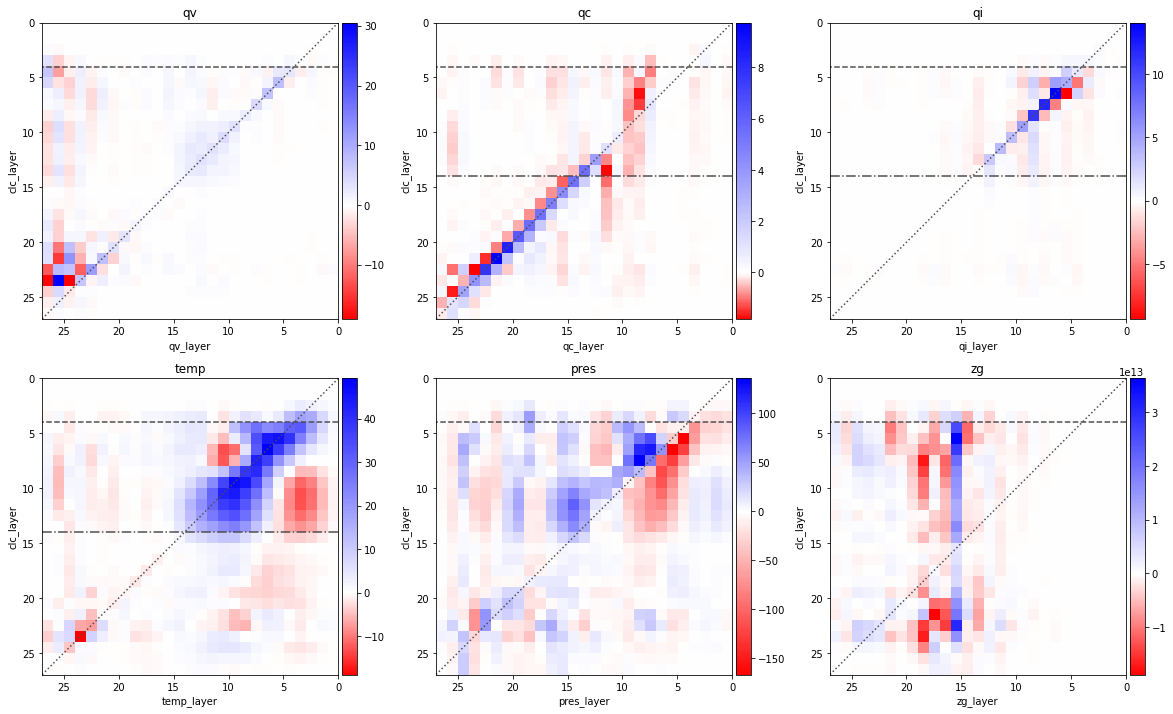

In [86]:
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import DivergingNorm

fig = plt.figure(figsize=(20,12))

# First plot
ax = fig.add_subplot(231, title='qv', xlabel='qv_layer', ylabel='clc_layer')
ax.plot([0, 27], [0, 27], ls=":", c=".3") # Diagonal
ax.plot([0, 27], [4, 4], ls="--", c=".3") # Tropopause
im = ax.imshow(np.flip(lin_reg.coef_[:, :27], axis=1), extent=(27,0,27,0), norm=DivergingNorm(0), cmap='bwr_r')
# Colorbar axes
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = fig.colorbar(im, cax=cax)

# Second plot
ax = fig.add_subplot(232, title='qc', xlabel='qc_layer',  ylabel='clc_layer')
ax.plot([0, 27], [0, 27], ls=":", c=".3") # Diagonal
ax.plot([0, 27], [4, 4], ls="--", c=".3") # Tropopause
ax.plot([0, 27], [14, 14], ls="-.", c=".3") # Freezing level
im = ax.imshow(np.flip(lin_reg.coef_[:, 27:54], axis=1), extent=(27,0,27,0), norm=DivergingNorm(0), cmap='bwr_r')
# Colorbar axes
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = fig.colorbar(im, cax=cax)

# Third plot
ax = fig.add_subplot(233, title='qi', xlabel='qi_layer',  ylabel='clc_layer')
ax.plot([0, 27], [0, 27], ls=":", c=".3") # Diagonal
ax.plot([0, 27], [4, 4], ls="--", c=".3") # Tropopause
ax.plot([0, 27], [14, 14], ls="-.", c=".3") # Freezing level
im = ax.imshow(np.flip(lin_reg.coef_[:, 54:81], axis=1), extent=(27,0,27,0), norm=DivergingNorm(0), cmap='bwr_r')
# Colorbar axes
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = fig.colorbar(im, cax=cax)

# Forth plot
ax = fig.add_subplot(234, title='temp', xlabel='temp_layer',  ylabel='clc_layer')
ax.plot([0, 27], [0, 27], ls=":", c=".3") # Diagonal
ax.plot([0, 27], [4, 4], ls="--", c=".3") # Tropopause
ax.plot([0, 27], [14, 14], ls="-.", c=".3") # Freezing level
im = ax.imshow(np.flip(lin_reg.coef_[:, 81:108], axis=1), extent=(27,0,27,0), 
                   norm=DivergingNorm(0), cmap='bwr_r')
# Colorbar axes
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = fig.colorbar(im, cax=cax)

# Fifth plot
ax = fig.add_subplot(235, title='pres', xlabel='pres_layer',  ylabel='clc_layer')
ax.plot([0, 27], [0, 27], ls=":", c=".3") # Diagonal
ax.plot([0, 27], [4, 4], ls="--", c=".3") # Tropopause
im = ax.imshow(np.flip(lin_reg.coef_[:, 108:135], axis=1), extent=(27,0,27,0), norm=DivergingNorm(0), cmap='bwr_r')
# Colorbar axes
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = fig.colorbar(im, cax=cax)

# Sixth plot
ax = fig.add_subplot(236, title='zg', xlabel='zg_layer',  ylabel='clc_layer')
ax.plot([0, 27], [0, 27], ls=":", c=".3") # Diagonal
ax.plot([0, 27], [4, 4], ls="--", c=".3") # Tropopause
im = ax.imshow(np.flip(lin_reg.coef_[:, 135:162], axis=1), extent=(27,0,27,0), norm=DivergingNorm(0), cmap='bwr_r')
# Colorbar axes
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = fig.colorbar(im, cax=cax)

plt.savefig('multiple linear regression coefficients R2B4 NARVAL normalized.pdf')

The MSE is higher (19.18 vs 18.56) than the one from the multiple linear model fitted on the preprocessed data. The reason is that the preprocessed data contains more predictors (rho and fr_lake). Note that on the other hand the preprocessed data has only been normalized w.r.t. the training set's mean and std (which doesn't really make a difference).

In [16]:
# Loss of this optimal multiple linear regression model
clc_predictions = lin_reg.predict(df_scaled)
lin_mse = mean_squared_error(output_data, clc_predictions)
print('The mean squared error of the linear model is %.2f.'%lin_mse) 

The mean squared error of the linear model is 19.21.


In [17]:
np.mean(clc_predictions)

3.6380519743798145

In [18]:
np.mean(np.array(output_data))

3.6382211847364165